In [222]:
from src.plotting.visutil import CSVPlotter
from src.plotting.postprocess import PostProcessor
from config.plotsetting import object_dict
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Produce ABCD table

Region A is defined as: OS + 2 b-tagged \
Region B is defined as: OS + 1 b-tagged \
Region C is defined as: SS + 2 b-tagged \
Region D is defined as: SS + 1 b-tagged

In [223]:
def add_inv_mass(df):
    # get deltaR and select OS
    from src.analysis.objutil import Object
    df.rename(columns=lambda x: x.replace('LDTau', 'LeadingTau'), inplace=True)
    df.rename(columns=lambda x: x.replace('SDTau', 'SubleadingTau'), inplace=True)
    leading_tau = Object.fourvector(df, 'LeadingTau', sort=False)
    subleading_tau = Object.fourvector(df, 'SubleadingTau', sort=False)
    df['Tau_dR'] = leading_tau.deltaR(subleading_tau)
    ld_jet = Object.fourvector(df, 'LDBjetBYtag', sort=False)
    sd_jet = Object.fourvector(df, 'SDBjetBYtag', sort=False)
    df['Bjet_dR'] = ld_jet.deltaR(sd_jet)
    df['Tau_InvM'] = (leading_tau+subleading_tau).mass
    df['Bjet_InvM'] = (ld_jet+sd_jet).mass
    df['OS'] = df['LeadingTau_charge']*df['SubleadingTau_charge'] < 0

In [224]:
def selOS(df):
    add_inv_mass(df)
    OS_df = df[df['OS']]
    return OS_df

def selSS(df):
    add_inv_mass(df)
    SS_df = df[~df['OS']]
    return SS_df

In [323]:
def regroup(df, keywords, new_value):
    mask = df['dataset'].apply(lambda x: any(keyword in x for keyword in keywords))
    df.loc[mask, 'group'] = new_value
    return df

In [324]:
cp = CSVPlotter(outdir='/Users/yuntongzhou/Desktop/Dihiggszztt/output/plots')
dfB = cp.postprocess_csv(datasource='/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_onelooseb',
                         per_evt_wgt='Generator_weight_values', extraprocess=selOS, selname='OS Tau')
dfA = cp.postprocess_csv(datasource='/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_twolooseb',
                         per_evt_wgt='Generator_weight_values', extraprocess=selOS, selname='OS Tau')

In [325]:
dfB = regroup(dfB, ['ZH_HToBB_ZToQQ', 'ZZto4L', 'ZZto2L2Nu', 'ZZto2Nu2Q'], 'Others')

In [326]:
dfA = regroup(dfA, ['ZH_HToBB_ZToQQ', 'ZZto4L', 'ZZto2L2Nu', 'ZZto2Nu2Q'], 'Others')

In [229]:
# save dataframes for further processing
dfB.to_csv("/Users/yuntongzhou/Desktop/Dihiggszztt/output/training/RegionB.csv")
dfA.to_csv("/Users/yuntongzhou/Desktop/Dihiggszztt/output/training/RegionA.csv")

In [233]:
# calculate total cutflow
inputpath1='/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_onelooseb_extrasel'
pp = PostProcessor()
_ = pp.merge_cf(inputdir=inputpath1, outputdir=inputpath1)
inputpath2='/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_twolooseb_extrasel'
_ = pp.merge_cf(inputdir=inputpath2, outputdir=inputpath2)

In [277]:
# get resolved cutflow tables
table1 = pd.read_csv('/Users/yuntongzhou/Desktop/Dihiggszztt/output/vetoskim/ResolvedWgtOnly.csv', index_col=0)
table2 = pd.read_csv('/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_twolooseb_extrasel/ResolvedWgtOnly.csv', index_col=0)

In [278]:
def drop_cols_wkwds(df: pd.DataFrame, keywords: list) -> pd.DataFrame:
    for keyword in keywords:
        cols_to_drop = df.filter(like=keyword).columns
        df = df.drop(columns=cols_to_drop)
    return df

In [284]:
table1 = drop_cols_wkwds(table1, ['QCD'])
rename_dict = {'ZH_HToBB_ZToLL_M-125': 'ZH_HToBB_ZToLL', 'ZH_HToBB_ZToQQ_M-125': 'ZH_HToBB_ZToQQ'}
table1 = table1.rename(columns=rename_dict)

In [317]:
# define regroup dictionary
regroup = {"DYJets": ["DYJets"], "TTbar": ['TTto'], "Others": ['ZZto4L', 'ZZto2L2Nu', 'ZZto2Nu2Q', 'WWto2L2Nu', 'WWto4Q', 'WWW_4F', 'WZto3LNu', 'WZto2L2Q', 'WZtoLNu2Q', 'ZH_HToBB_ZToQQ'], 
           "SingleH": ['ttHto2B', 'VBFHToTauTau', 'VBFHto2B', 'GluGluHToTauTau', 'GluGluHto2B']}

In [320]:
total_table = pd.concat([table1, table2], axis=0)
total_table.columns

Index(['DYJetsToLL_M-50', 'TTtoLNu2Q', 'TTto2L2N', 'TTto4Q', 'ttHto2B',
       'VBFHToTauTau', 'VBFHto2B', 'GluGluHToTauTau', 'GluGluHto2B',
       'WWto2L2Nu', 'WWto4Q', 'WWW_4F', 'WZto3LNu', 'WZto2L2Q', 'WZtoLNu2Q',
       'ZH_HToBB_ZToLL', 'ZH_HToBB_ZToQQ', 'GluGlutoHHto2B2Tau', 'ZZto4L',
       'ZZto2L2Nu', 'ZZto2Nu2Q', 'ZZto2L2Q'],
      dtype='object')

In [321]:
pp.present_yield(total_table.drop('Muon Veto'), ['GluGlutoHHto2B2Tau', 'ZH_HToBB_ZToLL', 'ZZto2L2Q'], regroup, 
              '/Users/yuntongzhou/Desktop/Dihiggszztt/output/')

,DYJets,Others,SingleH,TTbar,Tot Bkg,Bkg Eff,GluGlutoHHto2B2Tau,GluGlutoHHto2B2Tau Eff,ZH_HToBB_ZToLL,ZH_HToBB_ZToLL Eff,ZZto2L2Q,ZZto2L2Q Eff
initial,1.307009e+09,2.232590e+07,7.961796e+06,2.035935e+08,1.540890e+09,1.000000,547.562803,1.000000,12091.915576,1.000000,534362.185356,1.000000
HLT_DoubleMediumChargedIsoPFTauHPS40_Trk1_eta2p1,5.421614e+07,1.702556e+05,1.749251e+04,1.964806e+06,5.636869e+07,0.036582,41.083499,0.075030,810.317955,0.067013,11957.504819,0.022377
Electron Veto,1.396460e+06,2.937293e+04,1.307496e+04,6.418885e+05,2.080796e+06,0.036914,30.688215,0.746972,81.252029,0.100272,909.733176,0.076081
initial,1.265228e+06,2.715293e+04,1.280630e+04,5.806043e+05,1.885791e+06,0.906284,29.516917,0.961832,76.277274,0.938774,847.044357,0.931091
>= 2 Medium hadronic Taus,1.692649e+05,3.049541e+03,5.598024e+03,2.098557e+04,1.988980e+05,0.105472,13.857574,0.469479,27.688109,0.362993,198.010414,0.233766
Tau dR >= 0.5,1.692649e+05,3.048416e+03,5.598024e+03,2.098364e+04,1.988950e+05,0.999985,13.855574,0.999856,27.681865,0.999775,197.904164,0.999463
>=2 ak4 jets,4.410839e+04,1.448026e+03,1.412631e+03,1.755302e+04,6.452207e+04,0.324403,12.177184,0.878865,22.330328,0.806677,147.341762,0.744511
>=2 Loose B-tagged,2.626504e+03,8.558625e+01,7.145173e+01,8.454217e+03,1.123776e+04,0.174169,6.933879,0.569416,12.919868,0.578579,20.632947,0.140035
OS Tau,2.542166e+03,7.302578e+01,6.611272e+01,7.622340e+03,1.030364e+04,0.916877,6.750938,0.973616,12.645110,0.978734,19.655485,0.952626


In [109]:
def ABCDTable():
    AC_df = pd.read_csv(f'{inputpath2}/scaledyield.csv')
    AC_df.drop(columns=['Sig Eff', 'Bkg Eff'], inplace=True)
    AC_df = AC_df.apply(pd.to_numeric, errors='coerce')
    BD_df = pd.read_csv(f'{inputpath1}/scaledyield.csv')
    BD_df = BD_df.apply(pd.to_numeric, errors='coerce')
    BD_df.drop(columns=['Sig Eff', 'Bkg Eff'], inplace=True)
    A_row = AC_df.iloc[-1]
    C_row = AC_df.iloc[-2]-AC_df.iloc[-1]
    B_row = BD_df.iloc[-1]
    D_row = BD_df.iloc[-2]-BD_df.iloc[-1]
    ABCD_tab = pd.DataFrame([A_row, B_row, C_row, D_row])
    ABCD_tab['SvB Ratio'] = ABCD_tab['Tot Sig']/ABCD_tab['Tot Bkg']
    ABCD_tab.index = ['Region A', 'Region B', 'Region C', 'Region D']
    ABCD_tab = ABCD_tab.dropna(axis=1, how='any')
    ABCD_tab.to_csv('/Users/yuntongzhou/Desktop/Dihiggszztt/output/ABCD.csv')
    return ABCD_tab

In [110]:
ABCDTable()

,DYJets,SingleH,TTbar,WW,WWW,WZ,Tot Bkg,ggF,ZH,ZZ,Tot Sig,SvB Ratio
Region A,2542.166270,66.112722,7622.339871,11.455759,0.456910,58.877173,10301.408704,6.750938,12.754023,21.782515,41.287476,0.004008
Region B,12638.542262,331.089209,5329.562496,72.556388,3.236442,297.803209,18672.790007,3.453599,6.896976,49.916996,60.267571,0.003228
Region C,84.337270,5.339009,831.877334,2.464453,0.342682,9.207665,933.568414,0.182941,0.296541,1.501346,1.980828,0.002122
Region D,734.939064,10.094546,851.857929,10.348755,1.675335,52.667017,1661.582647,0.097930,0.271563,4.742555,5.112047,0.003077


In [327]:
dfD = cp.postprocess_csv(datasource='/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_onelooseb',
                         per_evt_wgt='Generator_weight_values', extraprocess=selSS, selname='SS Tau')
dfC = cp.postprocess_csv(datasource='/Users/yuntongzhou/Desktop/Dihiggszztt/output/datasource/prelim_twolooseb',
                         per_evt_wgt='Generator_weight_values', extraprocess=selSS, selname='SS Tau')

dfC = regroup(dfC, ['ZH_HToBB_ZToQQ', 'ZZto4L', 'ZZto2L2Nu', 'ZZto2Nu2Q'], 'Others')
dfD = regroup(dfD, ['ZH_HToBB_ZToQQ', 'ZZto4L', 'ZZto2L2Nu', 'ZZto2Nu2Q'], 'Others')

dfC.to_csv("/Users/yuntongzhou/Desktop/Dihiggszztt/output/training/RegionC.csv")
dfD.to_csv("/Users/yuntongzhou/Desktop/Dihiggszztt/output/training/RegionD.csv")

In [328]:
dfA[dfA.group=='ZZ']['weight'].sum()

1965.5485020584376

## Make Plots for Background vs Signal Distribution in four regions

In [ ]:
from config.plotsetting import tau_gen, bjetbytag_btag, H_mass, dR

In [185]:
bkg_only = {"DYJets": ["DYJets"], "TTbar": ["TTbar"], "SingleH": ["SingleH"], "Others": ["WZ", "WWW", "WW", "Others"], "QCD": ["QCD"]}
sig_only = {r"HH $\times 100$": ["ggF"], r"ZH $\times 100$": ["ZH"], r"ZZ $\times 100$": ["ZZ"]}
sig_total = {"Signal x 10": ["ZH", "ggF", "ZZ"]}
QCD_excluded = {"DYJets": ["DYJets"], "TTbar": ["TTbar"], "SingleH": ["SingleH"], "Others": ["WZ", "WWW", "WW", "Others"]}

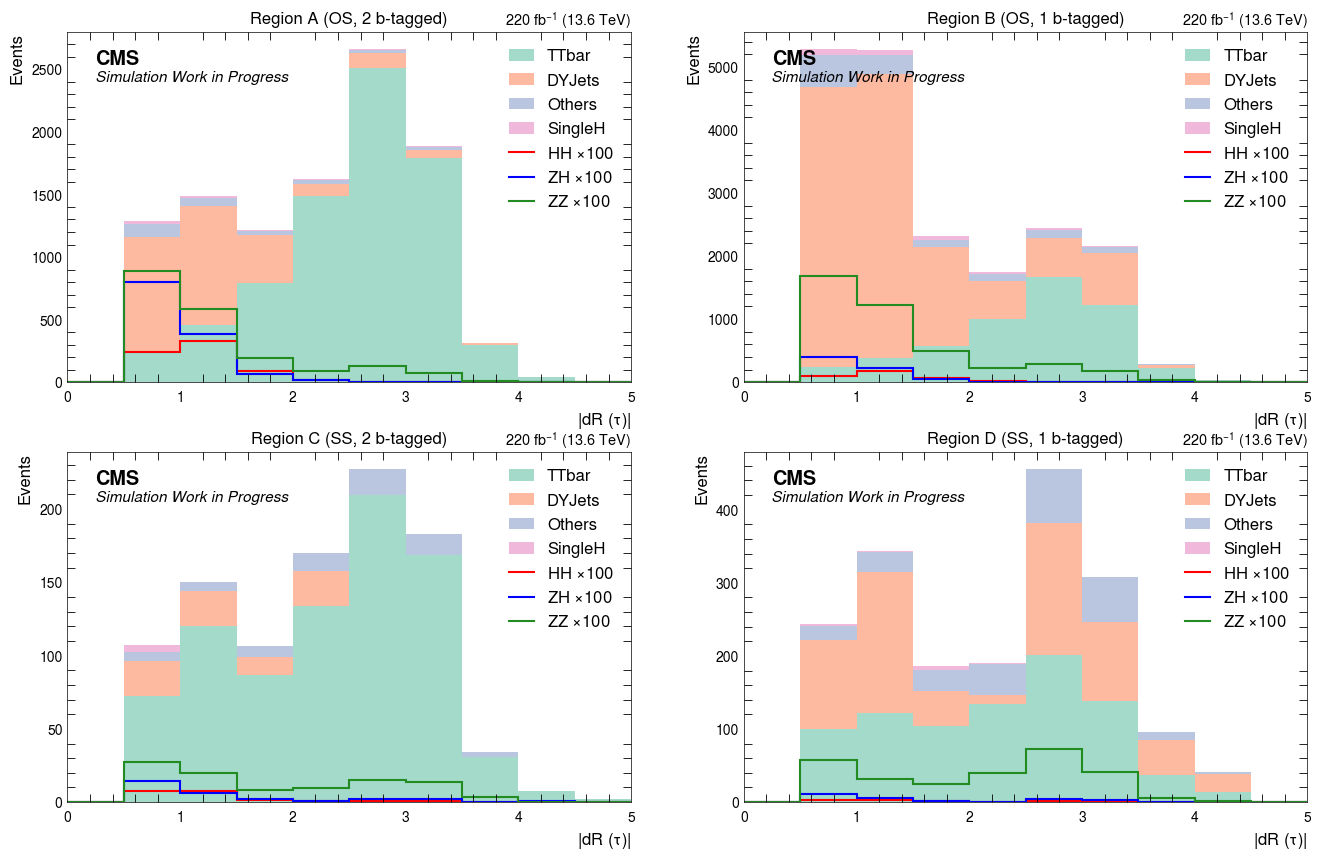

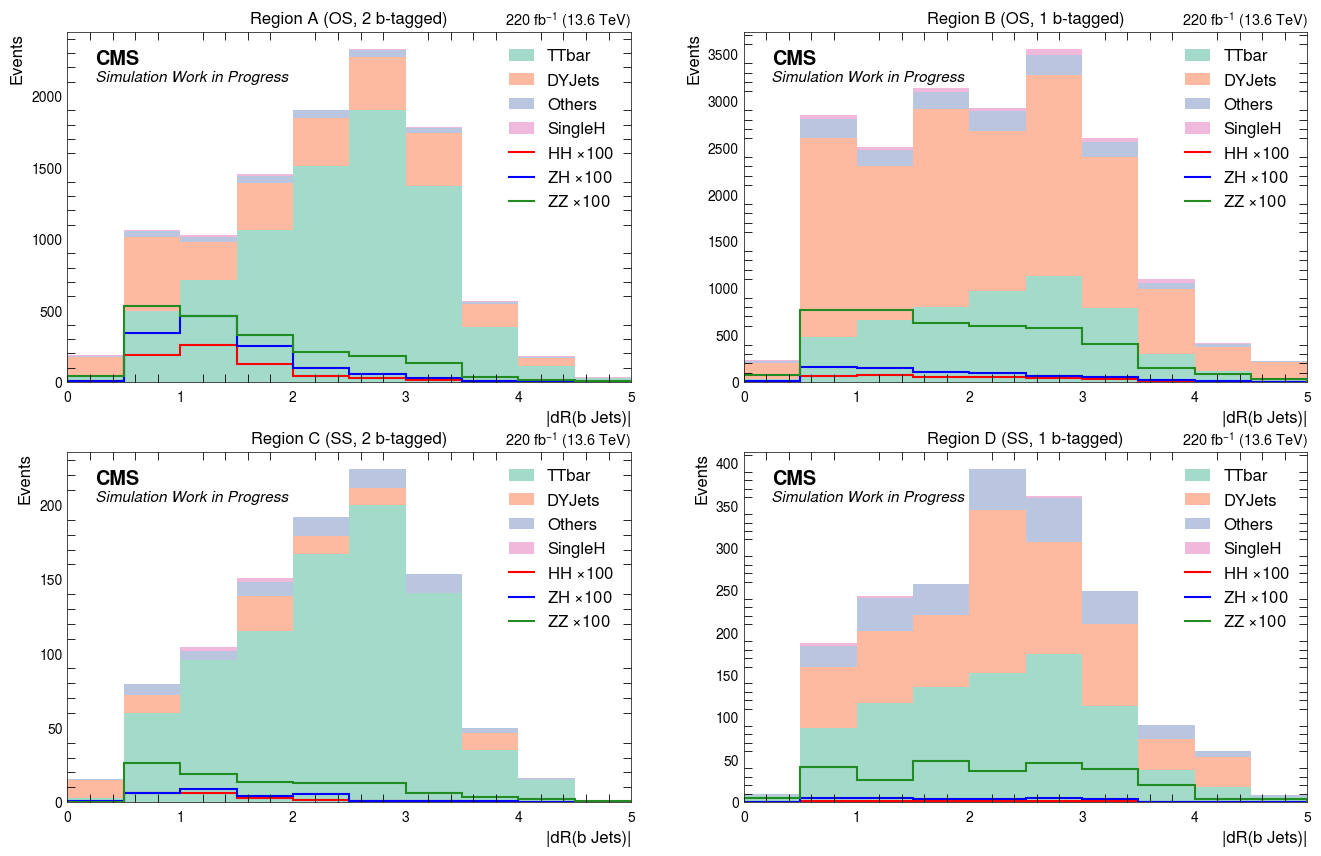

In [186]:
cp.plot_fourRegions(dfA, dfB, dfC, dfD, dR, QCD_excluded, sig_only, save_name='formal')

## Compare shape discrepancies between all four regions for TTbar dataset

In [187]:
filteredA = dfA[dfA.group=='TTbar']
filteredB = dfB[dfB.group=='TTbar']
filteredC = dfC[dfC.group=='TTbar']
filteredD = dfD[dfD.group=='TTbar']

In [210]:
from src.plotting.visutil import CSVPlotter

/Users/yuntongzhou/Desktop/Dihiggszztt/HHtobbtautau/src/plotting/visutil.py:284: RuntimeWarning: invalid value encountered in divide
  hep.histplot(bkg_hists, bins=bin_edges, label=bkg_label, ax=ax,
/Users/yuntongzhou/Desktop/Dihiggszztt/HHtobbtautau/src/plotting/visutil.py:285: RuntimeWarning: invalid value encountered in divide
  histtype='fill', alpha=0.6, stack=True, linewidth=1)
/Users/yuntongzhou/Desktop/Dihiggszztt/HHtobbtautau/src/plotting/visutil.py:284: RuntimeWarning: invalid value encountered in divide
  hep.histplot(bkg_hists, bins=bin_edges, label=bkg_label, ax=ax,
/Users/yuntongzhou/Desktop/Dihiggszztt/HHtobbtautau/src/plotting/visutil.py:285: RuntimeWarning: invalid value encountered in divide
  histtype='fill', alpha=0.6, stack=True, linewidth=1)


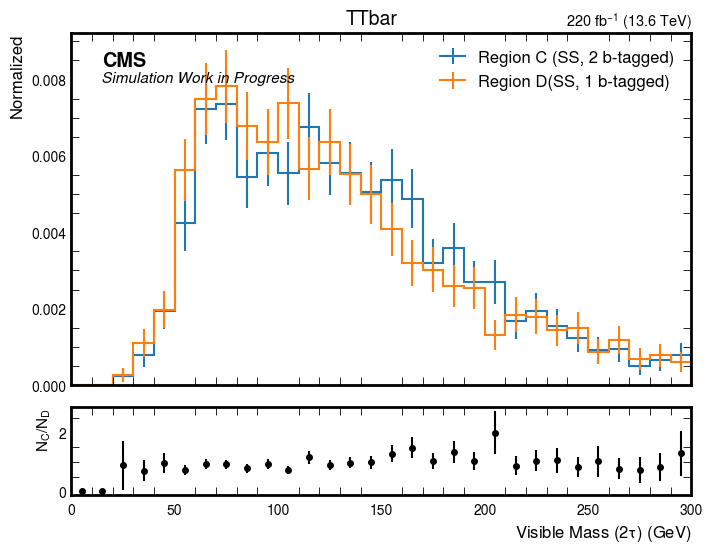

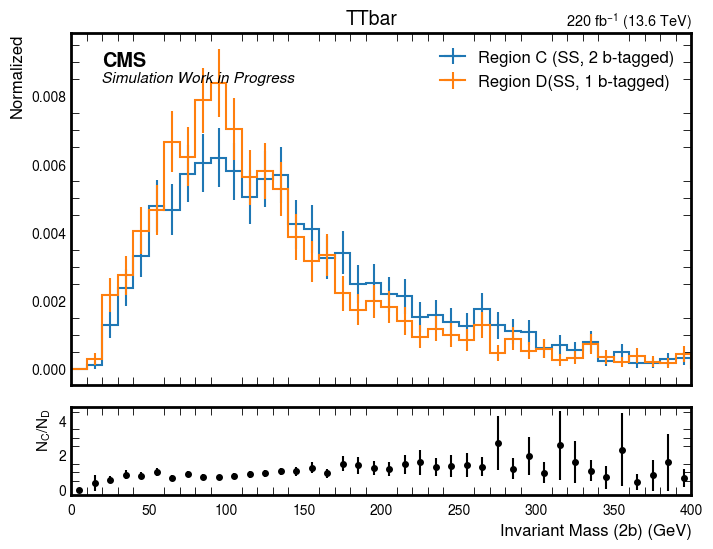

In [221]:
cp.plot_shape([filteredC, filteredD], ['Region C (SS, 2 b-tagged)', 'Region D(SS, 1 b-tagged)'], H_mass, ratio_ylabel=r'$N_C/N_D$', title='TTbar', save_name='TTbarRegionCvD')